In [1]:
import numpy as np
import time

import accbpg

from accbpg.utils import random_point_in_l2_ball
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib

# Суть эксперимента

Сравним скорость сходимости метода Франка-Вульфа с шагом вида:
$$\alpha_k = \alpha_k(L) := \min \{ (\frac{-\nabla f(x_k)^\top d_k}{2 L V(s^k, x^k)})^{1/(\gamma - 1)}, 1 \}$$
, где $V$ - дивергенция Брегмана, $1 < \gamma \leq 2$ - степень из свойства Triangle Scaling Exponent https://arxiv.org/pdf/1808.03045.pdf
с алгоритмами:

- BPG
- ABPG

## Постановка задачи
Рассмотрим задачу SVM в l2 шаре
$$
\textrm{minimize}_x \quad  f(x) := \frac{1}{n} \sum_{i=1}^n \max\{ 0, 1 - y_i x^\top \omega_i \} + \frac{\lambda}{2} \| x \|_2^2 \\
\textrm{s.t.} \ x\in \| x - c \| \leq R
$$

$x \in \mathbb{R}^n_{++}, y_i = \{ -1, 1\}, b \in \mathbb{R}_{++}$

Начальная точка выбирается случайно внутри шара. Радиус и центр возьмём следующие: $R=500, с = [500, 500,...]$

Для экспериментов возьмём дивергенцию The Itakura-Saito (IS) distance (см. https://arxiv.org/abs/1808.03045 с. 6). Она требует положительности x, поэтому шар будет лежать в области $\mathbb{R}_{++}^n$

В качестве тестовых данных взята выборка с банкнотами https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt 

Размер выборки: 1371 строка

LMO функция для метода FW

In [2]:
def lmo_notnegative_ball(radius, center=None):
    """
    The Frank-Wolfe lmo function for the l2 ball on x > 0 and x \in ||radius||_2
    """

    def f(g):
        if center is None:
            center_p = np.zeros(g)
        else:
            center_p = np.array([center] * g.shape[0])
        s = -1*g*radius/np.linalg.norm(g)
        s += center_p
        s[s == 0] = 1e-20
        return s

    return lambda g: f(g)

Вид кода с дивергенцией

In [3]:
from accbpg import BurgEntropy


class BurgEntropyL2Ball(BurgEntropy):
    """
    h(x) = - sum_{i=1}^n log(x[i]) used in context of solving the problem
            min_{x in ||B||_2} f(x)
    The ball must lie on the positive side of the axes! (x > 0)
    """
    def __init__(self, lamda=0, radius=1, center=None, delta=1e-30):
        assert lamda >= 0, "BurgEntropyL2Projection: lamda should be nonnegative."
        self.lamda = lamda
        self.radius = radius
        self.center = center
        self.delta = delta

    def div_prox_map(self, y, g, L):
        """
        Return argmin_{x in ||B||_inf, x > 0} { <g, x> + L * D(x,y) }
        B are with center in 0 + radius due to Burg entropy positiveness

        0 < x <= 2*radius
        """
        assert y.shape == g.shape, "Vectors y and g are of different sizes."
        assert L > 0, "L is not positive."
        x = L / (g - L * self.gradient(y))
        if self.center is None:
            center = np.zeros(x.shape)
        else:
            center = np.array([self.center] * x.shape[0])

        x -= center
        x /= max(self.radius, np.linalg.norm(x))
        x *= self.radius
        x += center
        x[x == 0] = self.delta

        assert np.linalg.norm(x - center) - self.radius <= 1e-12

        return x

Код алгоритма FW

In [4]:
def FW_alg_div_step(f, h, L, x0, maxitrs, gamma, lmo, epsilon=1e-14, linesearch=True, ls_ratio=2,
                    verbose=True, verbskip=1):
    """
    Classic Frank-Wolfe's algorithm

    Inputs:
        f, h, L:  f is L-smooth relative to h, and Psi is defined within h
        x0:       initial point to start algorithm
        gamma:    triangle scaling exponent (TSE) for Bregman distance D_h(x,y)
        maxitrs:  maximum number of iterations
        epsilon:  stop if D_h(z[k],z[k-1]) < epsilon
        theta_eq: calculate theta_k by solving equality using Newton's method
        verbose:  display computational progress (True or False)
        verbskip: number of iterations to skip between displays

    Returns (x, Fx, Ls):
        x: the last iterate of the algorithm
        F: array storing F(x[k]) for all k
        G: triangle scaling gains D(xk,yk)/D(zk,zk_1)/theta_k^gamma
        T: array storing time used up to iteration k
    """
    if verbose:
        print("\nFW adaptive algorithm")
        print("     k      F(x)         Lk       time")

    start_time = time.time()
    F = np.zeros(maxitrs)
    Ls = np.ones(maxitrs) * L
    T = np.zeros(maxitrs)
    delta = 1e-20

    x = np.copy(x0)
    for k in range(maxitrs):
        fx, g = f.func_grad(x)
        F[k] = fx + h.extra_Psi(x)
        T[k] = time.time() - start_time
        s_k = lmo(g)
        d_k = s_k - x
        div = h.divergence(s_k, x)
        if div == 0:
            div = delta

        grad_d_prod = np.dot(g, d_k)
        if 0 < grad_d_prod <= delta:
            grad_d_prod = 0
        assert grad_d_prod <= 0, "np.dot(g, d_k) must be negative."

        L = L / ls_ratio
        while True:
            alpha_k = min((-grad_d_prod / (2 * L * div)) ** (1 / (gamma - 1)), 1)
            x1 = x + alpha_k * d_k
            if not linesearch:
                break
            if f.func_grad(x1, flag=0) <= fx + alpha_k * grad_d_prod + alpha_k ** gamma * L * div:
                break
            L = L * ls_ratio
        x = x1
        x[x == 0] = delta

        Ls[k] = L
        if verbose and k % verbskip == 0:
            print("{0:6d}  {1:10.3e}  {2:10.3e}  {3:6.1f}".format(k, F[k], L, T[k]))

        # stopping criteria
        if k > 0 and abs(F[k] - F[k - 1]) < epsilon:
            break

    F = F[0:k + 1]
    Ls = Ls[0:k + 1]
    T = T[0:k + 1]
    return x, F, Ls, T

Функция, которая будет оптимизироваться:

$$\frac{1}{n} \sum_{i=1}^n \max\{ 0, 1 - y_i x^\top \omega_i \} + \frac{\lambda}{2} \| x \|_2^2$$

In [5]:
from accbpg import RSmoothFunction


class SoftMarginLoss(RSmoothFunction):
    def __init__(self, lamda, A, y):
        self.lamda = lamda
        self.A = A
        self.y = y

    def __call__(self, x):
        return self.F(x)

    def hinge_loss(self, x):
        return np.mean(np.maximum(0, 1 - self.y * np.dot(self.A, x)))

    def F(self, x):
        # return self.hinge_loss(x)
        return self.hinge_loss(x) + self.lamda * np.dot(x, x)

    def gradient(self, x):
        return self.func_grad(x, flag=1)

    def subgradient_loss(self, x):
        indicator = (1 - self.y * np.dot(self.A, x) < 1).astype(int)
        return np.mean(np.multiply(indicator[:, np.newaxis], np.multiply(self.y[:, np.newaxis], self.A)), axis=0)

    def func_grad(self, x, flag=2):

        if flag == 0:
            fx = self.F(x)
            return fx

        g = self.lamda * x - self.subgradient_loss(x)
        if flag == 1:
            return g

        fx = self.F(x)
        return fx, g

Подготовка данных для запуска алгоритмов

In [6]:
def svm_alg_banknote(radius=1, center=None):
    X = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt')
    Y = X['0'].to_numpy()
    X = X.to_numpy()

    f = SoftMarginLoss(0.5, X, Y)

    if center is None:
        center = np.array([radius + 1] * X.shape[1])

    h = BurgEntropyL2Ball(lamda=0.5, radius=radius, center=radius + 1)
    L = max(X.sum(axis=0))
    x0 = random_point_in_l2_ball(center, radius)
    assert np.linalg.norm(x0 - center) <= radius

    return f, h, L, x0

Запуск алгоритмов

In [12]:
radius = 1000
maxitrs = 1000
ls_ratio = 2.0
gamma = 2.0
f, h, L, x0 = accbpg.svm_alg_banknote(radius=radius)

In [13]:
x00_FW, F00_FW, G00_FW, T00_FW = accbpg.FW_alg_div_step(f, h, L, x0, lmo=accbpg.lmo_notnegative_ball(radius, center=radius),
                                                                maxitrs=maxitrs, gamma=gamma, ls_ratio=ls_ratio, verbskip=100)
x00, F00, G00, T00 = accbpg.BPG(f, h, L, x0, maxitrs=maxitrs, linesearch=True, ls_ratio=ls_ratio, verbskip=100)
x20, F20, G20, T20 = accbpg.ABPG(f, h, L, x0, gamma=gamma, maxitrs=maxitrs, theta_eq=True, verbskip=100)


FW adaptive algorithm
     k      F(x)         Lk       time
     0   2.499e+06   1.314e+03     0.0

BPG_LS method for min_{x in C} F(x) = f(x) + Psi(x)
     k      F(x)         Lk       time
     0   2.499e+06   1.314e+03     0.0

ABPG method for minimize_{x in C} F(x) = f(x) + Psi(x)
     k      F(x)       theta        TSG       D(x+,y)     D(z+,z)     time
     0   2.499e+06   1.000e+00   1.000e+00   7.118e-01   7.118e-01     0.0


Графики

## Выводы

Все алгоритмы справляются с задачей очень быстро в пределах 20 итераций. Метод FW иногда незначительно обходит конкуретнов, но в общем и целом с задачей все алгоритмы справляются примерно одинаково. Эксперимент запускаля много раз и картина сохранялась раз за разом

C:\Users\alexa\AppData\Local\Temp\ipykernel_18504\814589948.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 1, 1)


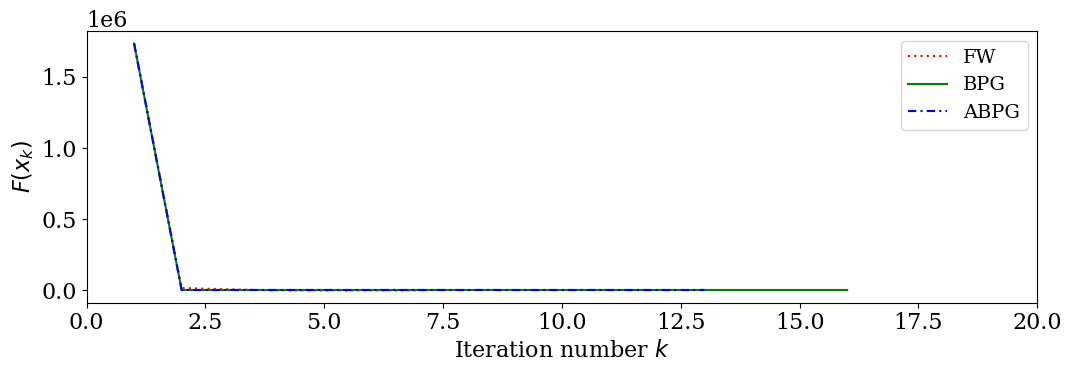

In [16]:
matplotlib.rcParams.update({'font.size': 16, 'legend.fontsize': 14, 'font.family': 'serif'})

fig, _ = plt.subplots(1, 2, figsize=(11, 4))

labels = [r"FW", r"BPG", r"ABPG"]
styles = ['r:', 'g-', 'b-.']
dashes = [[1, 2], [], [4, 2, 1, 2], [], [4, 2]]

ax1 = plt.subplot(1, 1, 1)
y_vals = [F00_FW, F00, F20]
accbpg.plot_comparisons(ax1, y_vals, labels, x_vals=[], plotdiff=True, yscale="linear", xlim=[0, 20],
                        ylim=[], xlabel=r"Iteration number $k$", ylabel=r"$F(x_k)$", legendloc="upper right",
                        linestyles=styles, linedash=dashes)

plt.tight_layout(w_pad=4)